In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df_train = pd.read_csv(r'C:\Users\ayush\Downloads\sdf-dsi-2022\train.csv')

C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Checking Null Values

In [379]:
df_train.isna().sum()/len(df_train)

transaction_id                        0.000000
current_ledger_sequence               0.000000
prior_ledger_sequence                 0.000000
prior_closed_at                       0.000000
prior_successful_transaction_count    0.000000
prior_failed_transaction_count        0.000000
prior_operation_count                 0.000000
prior_successful_operation_count      0.000000
prior_max_fee_charged                 0.000000
prior_min_fee_charged                 0.000000
prior_avg_fee_charged                 0.000000
account                               0.000000
time_bounds                           0.211558
transaction_operation_count           0.000000
memo_type                             0.000000
memo                                  0.949355
fee_account                           0.999687
max_fee_bid                           0.000000
new_max_fee_bid                       0.999687
operation_types                       0.000000
surge_price_ind                       0.000000
fee_charged  

### Dropping Columns

In [3]:
# put in 'current_ledger_sequence' in df_train
df_train_1 = df_train.drop(['new_max_fee_bid', 'fee_account', 'memo','account','current_ledger_sequence','memo_type','operation_types'], axis=1)

In [277]:
df_train_1.shape

(10091404, 15)

# Pre - Processing Time Bounds

In [4]:
#replacing null values with 0
df_train_1['time_bounds'].fillna(0, inplace = True)

In [5]:
#getting valid after and replacing the string [validbefore, validafter] with validafter
preprocess_time_bounds = df_train_1['time_bounds'].astype(str).apply(lambda row : row.split(',')[1][:-1] if (len(row.split(',')) == 2 and row.split(',')[1] != ')') else -1).astype(float)

#replacing (validbefore,) with max value of validafter
preprocess_time_bounds[preprocess_time_bounds == -1] = max(preprocess_time_bounds)

df_train_1['time_bounds'] = preprocess_time_bounds

# Need to preprocess memo type

In [146]:
df_train_1.columns

Index(['transaction_id', 'prior_ledger_sequence', 'prior_closed_at',
       'prior_successful_transaction_count', 'prior_failed_transaction_count',
       'prior_operation_count', 'prior_successful_operation_count',
       'prior_max_fee_charged', 'prior_min_fee_charged',
       'prior_avg_fee_charged', 'time_bounds', 'transaction_operation_count',
       'max_fee_bid', 'surge_price_ind', 'fee_charged', 'prior_month',
       'prior_day', 'prior_time', 'prior_time_seconds', 'avg_count_block',
       'smooth_avg1', 'smooth_avg2', 'smooth_avg3', 'smooth_avg2_fee',
       'smooth_avg1_fee', 'prior_avg_count_block'],
      dtype='object')

# Checking Operation Types

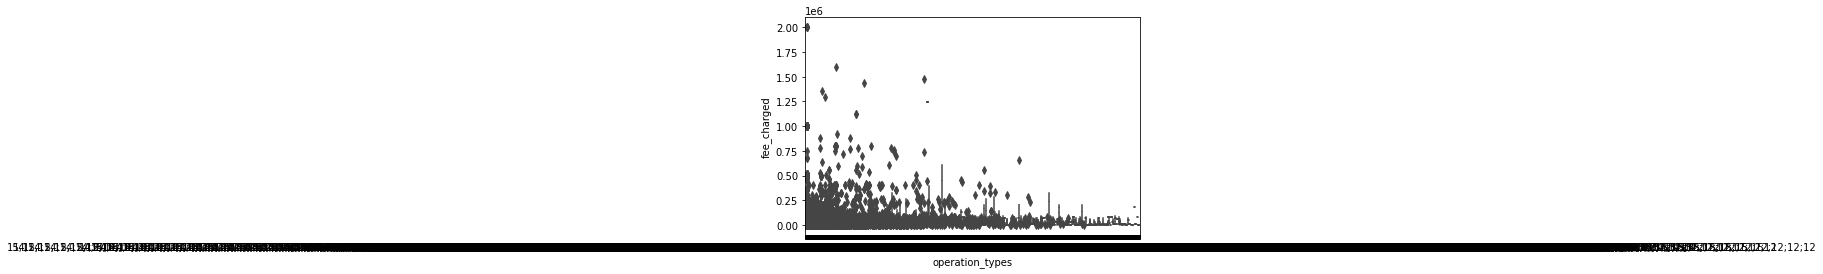

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.boxplot(x = df_train['operation_types'], y= df_train['fee_charged'], data=df_train)

# show plot
plt.show()

In [67]:
#No need to include it as on operation level
df_train_1.columns

Index(['transaction_id', 'prior_ledger_sequence', 'prior_closed_at',
       'prior_successful_transaction_count', 'prior_failed_transaction_count',
       'prior_operation_count', 'prior_successful_operation_count',
       'prior_max_fee_charged', 'prior_min_fee_charged',
       'prior_avg_fee_charged', 'time_bounds', 'transaction_operation_count',
       'max_fee_bid', 'surge_price_ind', 'fee_charged', 'prior_month',
       'prior_day', 'prior_time', 'prior_time_seconds', 'avg_count_block',
       'smooth_avg1', 'smooth_avg2', 'smooth_avg3', 'prior_avg_count_block',
       'smooth_avg1_fee', 'smooth_avg2_fee'],
      dtype='object')

# Preprocessing Prior Time

In [6]:
df_train_1['prior_month']=df_train_1['prior_closed_at'].str[5:7]
df_train_1['prior_day']=df_train_1['prior_closed_at'].str[8:10]
df_train_1['prior_time']=df_train_1['prior_closed_at'].str[11:19]
df_train_1['prior_time']=df_train_1['prior_time'].apply(lambda x: int(x[0:2])*3600 + int(x[3:5])*60 + int(x[6:8]))
df_train_1['prior_day']=df_train_1['prior_day'].astype(int)
df_train_1['prior_month']=df_train_1['prior_month'].astype(int)
df_train_1['prior_time_seconds']=df_train_1.apply(lambda x: x['prior_time']+86400*x['prior_day']+86400*31*x['prior_month'],axis=1)
df_train_1=df_train_1.sort_values(by=['prior_time_seconds'],inplace=False)

df_train_1['avg_count_block'] = df_train_1.groupby(['prior_time_seconds'])['transaction_id'].transform('count')
# df_train_1['smooth_avg1']=df_train_1['avg_count_block'].rolling(window=100000).ewm(alpha = 0.5)
# df_train_1['smooth_avg2']=df_train_1['avg_count_block'].rolling(window=10000).mean()
# df_train_1['smooth_avg3']=df_train_1['avg_count_block'].rolling(window=500000).mean()

In [7]:
df_train_1['smooth_avg1']=df_train_1['avg_count_block'].rolling(window=100000).mean()
df_train_1['smooth_avg2']=df_train_1['avg_count_block'].rolling(window=10000).mean()
df_train_1['smooth_avg3']=df_train_1['avg_count_block'].rolling(window=500000).mean()
df_train_1['exp_smooth_avg_count_block'] = df_train_1['avg_count_block'].ewm(alpha = 0.5).mean()

In [8]:
right_table = df_train_1.groupby(['prior_time_seconds'])['transaction_id'].count().rolling(window=100).mean().fillna(method = 'bfill')

In [9]:
# df.rename({'a': 'X', 'b': 'Y'}, axis=1, inplace=True)
right_table = pd.DataFrame(right_table).reset_index()
right_table.rename({'transaction_id': 'prior_avg_count_block'}, axis=1, inplace=True)

In [10]:
df_train_1 = pd.merge(df_train_1,right_table,on = 'prior_time_seconds',how = 'left')

# Prior avg fee smoothing

In [11]:
df_train_1['smooth_avg1_fee'] = df_train_1['prior_avg_fee_charged'].rolling(window=100000).mean().fillna(method = 'bfill')
df_train_1['smooth_avg2_fee'] = df_train_1['prior_avg_fee_charged'].rolling(window=10000).mean().fillna(method = 'bfill')

In [12]:
df_train_1['exp_smooth_avg2_fee'] = df_train_1['prior_avg_fee_charged'].ewm(alpha = 0.5).mean()

In [13]:
df_train_1=df_train_1.fillna(method='bfill') 

In [14]:
df_train_1.drop('transaction_id',axis = 1,inplace = True)

# prior_time_seconds

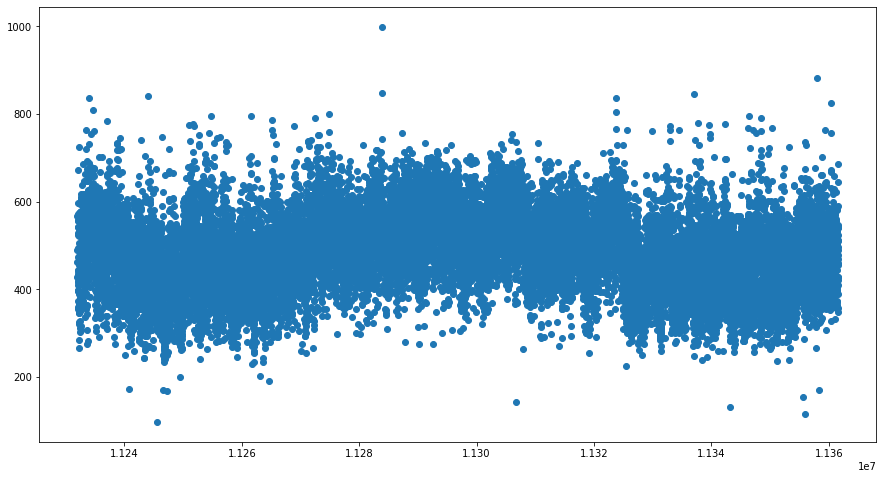

In [32]:
plt.figure(figsize=(15,8))
plt.scatter(df_train_1.groupby(['prior_time_seconds']).first().index,df_train_1.groupby(['prior_time_seconds']).first()['avg_count_block'])
plt.show()

In [138]:
temp = df_train_1.groupby(['prior_time_seconds']).first()

# avg_count_block 

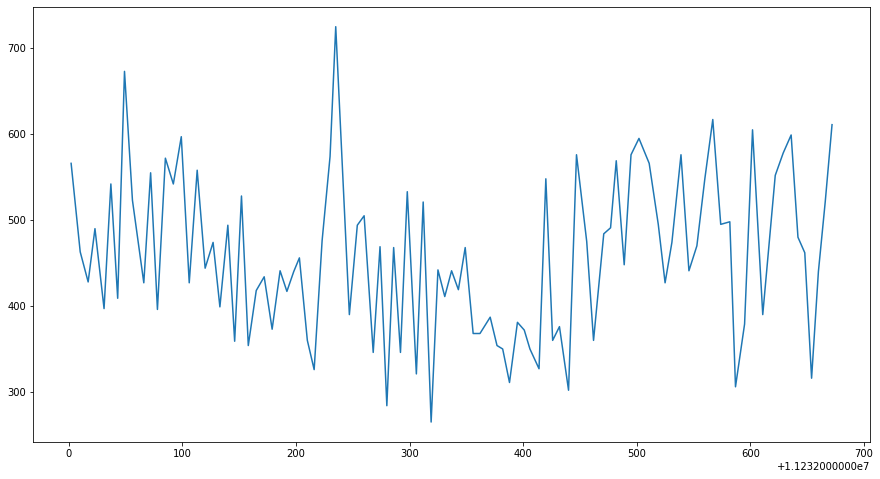

In [48]:
plt.figure(figsize=(15,8))
plt.plot(temp['avg_count_block'].index[0:100],temp['avg_count_block'][0:100])
plt.show()

# prior_avg_count_block

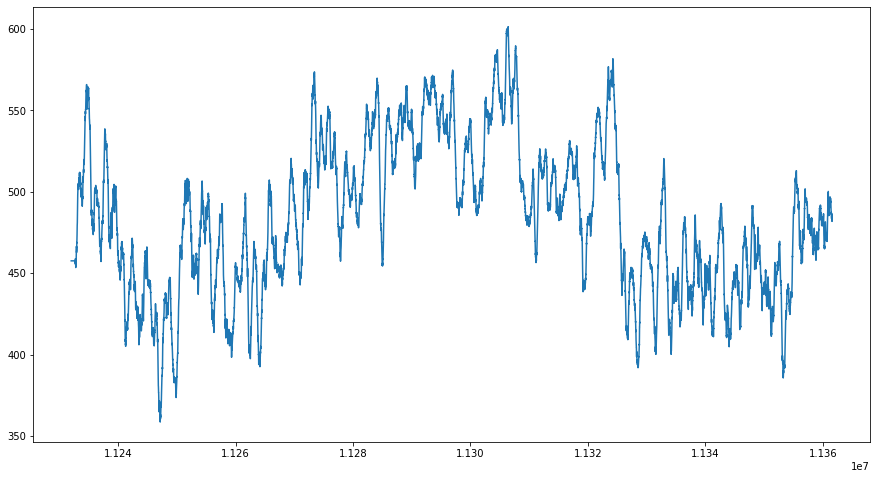

In [142]:
plt.figure(figsize=(15,8))
plt.plot(temp['prior_avg_count_block'].index,temp['prior_avg_count_block'])
plt.show()

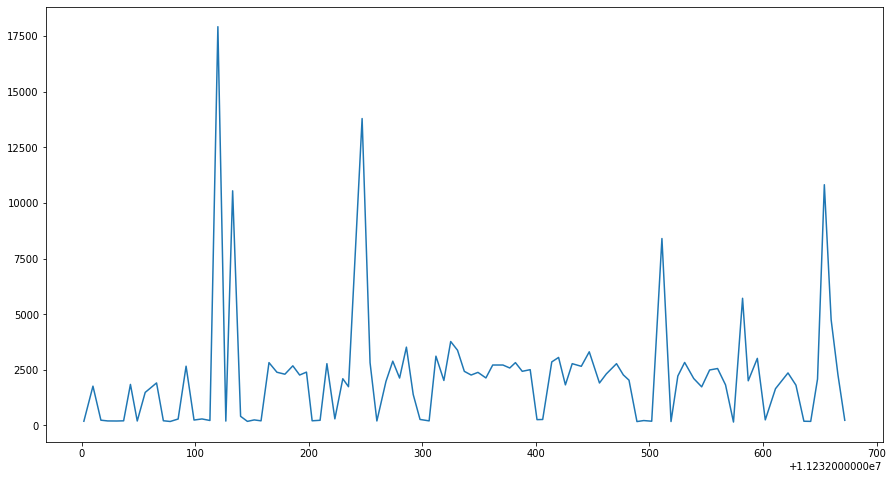

In [51]:
plt.figure(figsize=(15,8))
plt.plot(temp['prior_avg_fee_charged'].index[0:100],temp['prior_avg_fee_charged'][0:100])
plt.show()

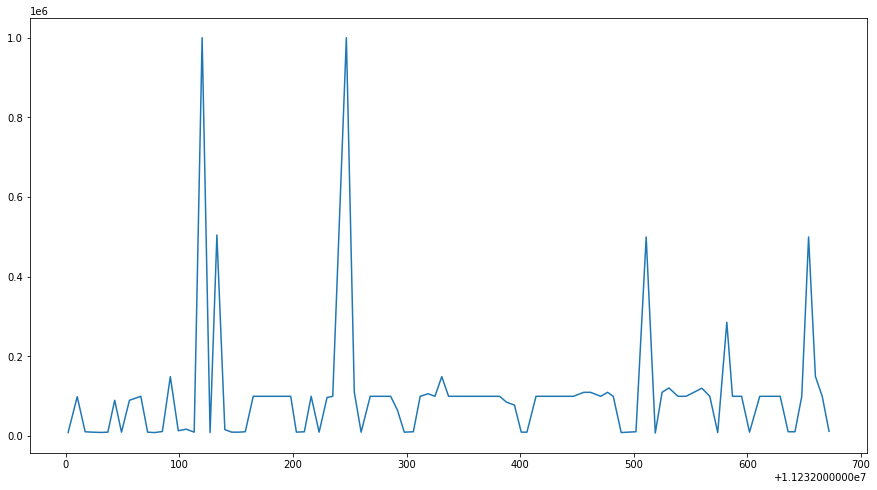

In [52]:
plt.figure(figsize=(15,8))
plt.plot(temp['prior_max_fee_charged'].index[0:100],temp['prior_max_fee_charged'][0:100])
plt.show()

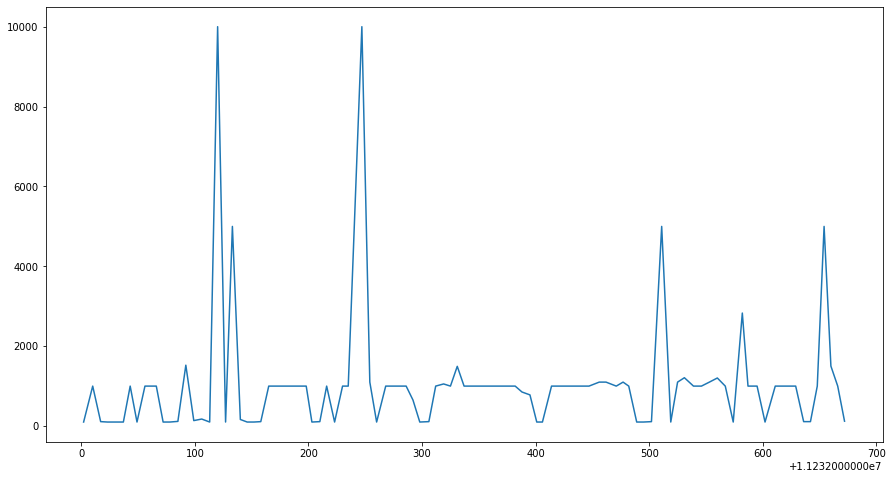

In [53]:
plt.figure(figsize=(15,8))
plt.plot(temp['prior_min_fee_charged'].index[0:100],temp['prior_min_fee_charged'][0:100])
plt.show()

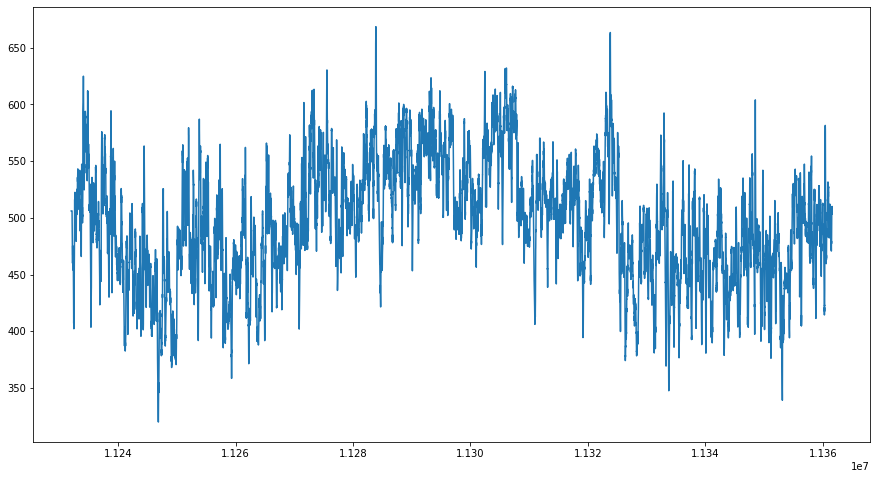

In [68]:
plt.figure(figsize=(15,8))
plt.plot(temp['smooth_avg2'].index,temp['smooth_avg2'])
plt.show()

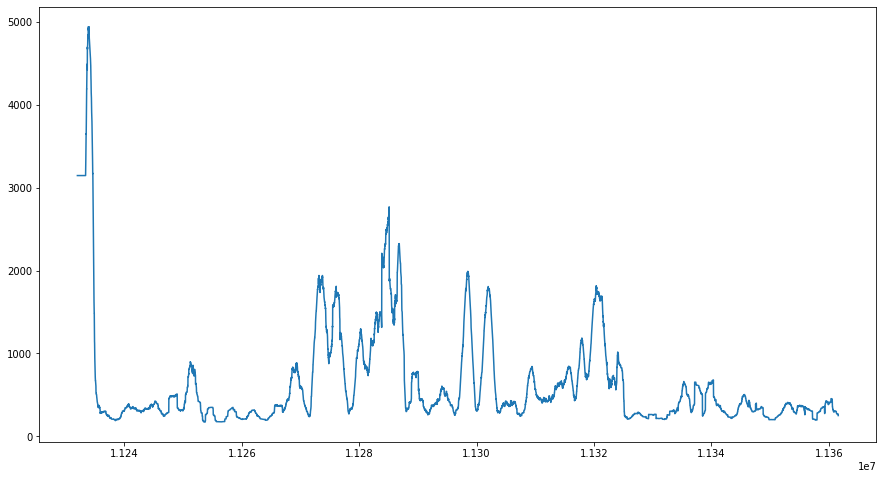

In [98]:
temp = df_train_1.groupby(['prior_time_seconds']).first()

plt.figure(figsize=(15,8))
plt.plot(temp['smooth_avg1_fee'].index,temp['smooth_avg1_fee'] )
plt.show()

In [92]:
df_train_1['smooth_avg2_fee']

2126111    1830.801930
6378100    1830.801930
7546902    1830.801930
1070828    1830.801930
9205363    1830.801930
              ...     
5696150     266.245187
9499440     266.243304
5443341     266.241422
7127039     266.239540
5977822     266.237657
Name: smooth_avg2_fee, Length: 10091404, dtype: float64

In [159]:
df_train_1.columns

Index(['transaction_id', 'prior_ledger_sequence', 'prior_closed_at',
       'prior_successful_transaction_count', 'prior_failed_transaction_count',
       'prior_operation_count', 'prior_successful_operation_count',
       'prior_max_fee_charged', 'prior_min_fee_charged',
       'prior_avg_fee_charged', 'time_bounds', 'transaction_operation_count',
       'max_fee_bid', 'surge_price_ind', 'fee_charged', 'prior_month',
       'prior_day', 'prior_time', 'prior_time_seconds', 'avg_count_block',
       'smooth_avg1', 'smooth_avg2', 'smooth_avg3', 'prior_avg_count_block',
       'smooth_avg1_fee', 'smooth_avg2_fee'],
      dtype='object')

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# ohe_features = [
#     'memo_type'
# ]



num_features = ['prior_ledger_sequence', 'prior_successful_transaction_count', 'prior_failed_transaction_count',
       'prior_operation_count', 'prior_successful_operation_count',
       'prior_max_fee_charged', 'prior_min_fee_charged',
       'prior_avg_fee_charged','max_fee_bid', 'transaction_operation_count','time_bounds','smooth_avg1', 'smooth_avg2', 'smooth_avg3','prior_avg_count_block',
       'smooth_avg1_fee', 'smooth_avg2_fee','exp_smooth_avg_count_block','exp_smooth_avg2_fee']

In [47]:
# df_train_merge = pd.merge(df_train_2,df_train_2.groupby('account')['prior_ledger_sequence'].count(), on = 'account',how = 'left')

In [48]:
# df_train_merge = df_train_merge.drop('account', axis = 1)

In [161]:
df_train_1.columns

Index(['prior_ledger_sequence', 'prior_successful_transaction_count',
       'prior_failed_transaction_count', 'prior_operation_count',
       'prior_successful_operation_count', 'prior_max_fee_charged',
       'prior_min_fee_charged', 'prior_avg_fee_charged', 'time_bounds',
       'transaction_operation_count', 'max_fee_bid', 'surge_price_ind'],
      dtype='object')

In [29]:
# mixed_df = df_train_merge[ohe_features + num_features]

,memo_type,prior_ledger_sequence_x,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,memo_type,max_fee_bid,prior_ledger_sequence_y,transaction_operation_count,operation_types
0,MemoTypeMemoNone,40360614,282,298,938,615,9000,100,161.896552,MemoTypeMemoNone,24042,5706,1,2
1,MemoTypeMemoNone,40365891,329,142,1000,832,9000,100,212.314225,MemoTypeMemoNone,24042,3151,1,2
2,MemoTypeMemoNone,40360069,177,268,964,671,10000,100,216.853933,MemoTypeMemoNone,24042,3485,1,2
3,MemoTypeMemoNone,40358776,275,285,966,659,11000,110,189.750000,MemoTypeMemoNone,24042,2738,1,2
4,MemoTypeMemoNone,40357030,290,220,943,711,5600,100,185.098039,MemoTypeMemoNone,24042,6332,1,2


# Doing Train Test Split

(10091404, 26)

In [24]:
from sklearn.model_selection import train_test_split
X = df_train_1.drop(['surge_price_ind','fee_charged','prior_closed_at'],axis = 1)
y = df_train_1['surge_price_ind']

X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [ ]:
X.isna().sum()/len(df_train)

# Running Logistic Regression

In [173]:
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression

preprocess = make_column_transformer((StandardScaler(), num_features),
                                     remainder = "passthrough")    
#code here
pipe = sklearn.pipeline.make_pipeline(preprocess, LogisticRegression())
pipe = pipe.fit(X_dev, y_dev)

In [174]:
print(pipe.score(X_dev,y_dev))
print(pipe.score(X_test,y_test))

0.7019636638758012
0.7022768385571682


In [25]:
scaler = StandardScaler()

X_dev_norm = scaler.fit_transform(X_dev[num_features])

In [26]:
import statsmodels.api as sm

X_dev_norm = sm.add_constant(X_dev_norm)
log_reg = sm.Logit(y_dev, X_dev_norm).fit()

Optimization terminated successfully.
         Current function value: 0.441905
         Iterations 7


In [27]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:        surge_price_ind   No. Observations:              8073123
Model:                          Logit   Df Residuals:                  8073103
Method:                           MLE   Df Model:                           19
Date:                Mon, 18 Apr 2022   Pseudo R-squ.:                  0.2746
Time:                        11:24:02   Log-Likelihood:            -3.5675e+06
converged:                       True   LL-Null:                   -4.9181e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0790      0.001  -1022.865      0.000      -1.081      -1.077
x1             0.1248      0.001    112.504      0.000       0.123       0.127
x2            -0.2010      0.001   -170.063      0.0

transaction_id                          int64
prior_ledger_sequence                   int64
prior_successful_transaction_count      int64
prior_failed_transaction_count          int64
prior_operation_count                   int64
prior_successful_operation_count        int64
prior_max_fee_charged                   int64
prior_min_fee_charged                   int64
prior_avg_fee_charged                 float64
time_bounds                           float64
transaction_operation_count             int64
max_fee_bid                             int64
prior_month                             int32
prior_day                               int32
prior_time                              int64
prior_time_seconds                      int64
avg_count_block                         int64
smooth_avg1                           float64
smooth_avg2                           float64
smooth_avg3                           float64
prior_avg_count_block                 float64
smooth_avg1_fee                   

# Using Random Forest

In [28]:
X = X[['prior_ledger_sequence', 'prior_successful_transaction_count', 'prior_failed_transaction_count',
       'prior_operation_count', 'prior_successful_operation_count',
       'prior_max_fee_charged', 'prior_min_fee_charged',
       'prior_avg_fee_charged','max_fee_bid', 'transaction_operation_count','time_bounds','smooth_avg1', 'smooth_avg2', 'smooth_avg3','smooth_avg2_fee','prior_avg_count_block']]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf2 = RandomForestClassifier(n_estimators=500, min_samples_split=5,random_state=0,max_samples=200,n_jobs=-1)
#l=5000000
#clf2.fit(X_train[:l], y_train[:l])
clf2.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = clf2.predict(X_test)
print(accuracy_score(y_test, y_pred))

# import pickle
# pickle.dump(clf2, open('classifier.sav', 'wb')) 


0.8584333984752703


array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

# Trying HistClassifier

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

n_estimators = [40,80]
max_depth = [20,30]
learning_rate = [0.1,0.05]
grid = { 'n_estimators':n_estimators,
         'max_depth': max_depth,
         'learning_rate': learning_rate
        }
ohe_features = [
    'descMapName'
]
preprocess = make_column_transformer((StandardScaler(), num_features),
                                     remainder = "passthrough") 
pipe = sklearn.pipeline.make_pipeline(preprocess,HistGradientBoostingClassifier(verbose = 5,random_state = 42,max_iter =200, max_depth = None, learning_rate = 0.05))
pipe.fit(X_train,y_train)

Binning 1.168 GB of training data: 1.910 s
Binning 0.130 GB of validation data: 0.176 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.62939, val loss: 0.62947, in 0.677s
[2/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.61315, val loss: 0.61329, in 0.673s
[3/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.59853, val loss: 0.59872, in 0.687s
[4/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.58522, val loss: 0.58546, in 0.682s
[5/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.57311, val loss: 0.57338, in 0.675s
[6/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.56203, val loss: 0.56235, in 0.658s
[7/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.55165, val loss: 0.55200, in 0.689s
[8/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.54221, val loss: 0.54259, in 0.660s
[9/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.53343, val loss: 0.53383, in 0.675s
[10/200] 1 tree, 31 leaves, max depth = 9, train lo

[88/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.37622, val loss: 0.37721, in 0.576s
[89/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.37544, val loss: 0.37639, in 0.528s
[90/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.37488, val loss: 0.37581, in 0.561s
[91/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.37438, val loss: 0.37531, in 0.526s
[92/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.37376, val loss: 0.37470, in 0.580s
[93/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.37307, val loss: 0.37401, in 0.689s
[94/200] 1 tree, 31 leaves, max depth = 10, train loss: 0.37259, val loss: 0.37352, in 0.593s
[95/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.37197, val loss: 0.37287, in 0.500s
[96/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.37121, val loss: 0.37213, in 0.622s
[97/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.37058, val loss: 0.37151, in 0.554s
[98/200] 1 tree, 31 leaves, max depth = 10, train loss: 0.37006

[175/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.33254, val loss: 0.33339, in 0.563s
[176/200] 1 tree, 31 leaves, max depth = 14, train loss: 0.33200, val loss: 0.33287, in 0.737s
[177/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.33150, val loss: 0.33236, in 0.559s
[178/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.33117, val loss: 0.33203, in 0.491s
[179/200] 1 tree, 31 leaves, max depth = 14, train loss: 0.33066, val loss: 0.33153, in 0.607s
[180/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.33032, val loss: 0.33118, in 0.508s
[181/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.32975, val loss: 0.33061, in 0.588s
[182/200] 1 tree, 31 leaves, max depth = 15, train loss: 0.32922, val loss: 0.33009, in 0.558s
[183/200] 1 tree, 31 leaves, max depth = 15, train loss: 0.32871, val loss: 0.32957, in 0.581s
[184/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.32828, val loss: 0.32913, in 0.564s
[185/200] 1 tree, 31 leaves, max depth = 14, train lo

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['prior_ledger_sequence',
                                                   'prior_successful_transaction_count',
                                                   'prior_failed_transaction_count',
                                                   'prior_operation_count',
                                                   'prior_successful_operation_count',
                                                   'prior_max_fee_charged',
                                                   'prior_min_fee_charged',
                                                   'prior_avg_fee_charged',
                                                   'max_fee_bid',
                                                   'transac

In [23]:
print(pipe.score(X_dev,y_dev))
print(pipe.score(X_test,y_test))

0.8567441620795323
0.8480543300570182


In [292]:
pipe.fit(X,y)

Binning 1.598 GB of training data: 2.049 s
Binning 0.178 GB of validation data: 0.196 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.59055, val loss: 0.59054, in 0.946s
[2/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.57409, val loss: 0.57407, in 0.970s
[3/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.55937, val loss: 0.55933, in 1.002s
[4/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.54608, val loss: 0.54603, in 1.181s
[5/200] 1 tree, 31 leaves, max depth = 6, train loss: 0.53406, val loss: 0.53401, in 0.996s
[6/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.52307, val loss: 0.52300, in 0.935s
[7/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.51309, val loss: 0.51301, in 0.942s
[8/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.50386, val loss: 0.50377, in 1.042s
[9/200] 1 tree, 31 leaves, max depth = 7, train loss: 0.49542, val loss: 0.49531, in 1.011s
[10/200] 1 tree, 31 leaves, max depth = 9, train lo

[88/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.35127, val loss: 0.35080, in 0.870s
[89/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.35079, val loss: 0.35033, in 0.764s
[90/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.35040, val loss: 0.34994, in 0.769s
[91/200] 1 tree, 31 leaves, max depth = 10, train loss: 0.34994, val loss: 0.34949, in 0.784s
[92/200] 1 tree, 31 leaves, max depth = 14, train loss: 0.34938, val loss: 0.34891, in 1.058s
[93/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.34894, val loss: 0.34848, in 0.883s
[94/200] 1 tree, 31 leaves, max depth = 9, train loss: 0.34841, val loss: 0.34794, in 0.819s
[95/200] 1 tree, 31 leaves, max depth = 14, train loss: 0.34790, val loss: 0.34744, in 0.871s
[96/200] 1 tree, 31 leaves, max depth = 13, train loss: 0.34738, val loss: 0.34693, in 0.901s
[97/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.34685, val loss: 0.34642, in 0.763s
[98/200] 1 tree, 31 leaves, max depth = 10, train loss: 0.346

[175/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.31643, val loss: 0.31611, in 0.685s
[176/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.31617, val loss: 0.31585, in 0.664s
[177/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.31583, val loss: 0.31549, in 0.685s
[178/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.31556, val loss: 0.31523, in 0.687s
[179/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.31517, val loss: 0.31485, in 0.787s
[180/200] 1 tree, 31 leaves, max depth = 16, train loss: 0.31473, val loss: 0.31441, in 0.795s
[181/200] 1 tree, 31 leaves, max depth = 10, train loss: 0.31444, val loss: 0.31411, in 0.635s
[182/200] 1 tree, 31 leaves, max depth = 8, train loss: 0.31420, val loss: 0.31388, in 0.659s
[183/200] 1 tree, 31 leaves, max depth = 11, train loss: 0.31401, val loss: 0.31368, in 0.612s
[184/200] 1 tree, 31 leaves, max depth = 12, train loss: 0.31370, val loss: 0.31337, in 0.750s
[185/200] 1 tree, 31 leaves, max depth = 14, train 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['prior_ledger_sequence',
                                                   'prior_successful_transaction_count',
                                                   'prior_failed_transaction_count',
                                                   'prior_operation_count',
                                                   'prior_successful_operation_count',
                                                   'prior_max_fee_charged',
                                                   'prior_min_fee_charged',
                                                   'prior_avg_fee_charged',
                                                   'max_fee_bid',
                                                   'transac

In [26]:
pipe['histgradientboostingclassifier'].predict(X)

C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Trying XgbClassifier

In [322]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

n_estimators = [40,80]
max_depth = [20,30]
learning_rate = [0.1,0.05]
grid = { 'n_estimators':n_estimators,
         'max_depth': max_depth,
         'learning_rate': learning_rate
        }
ohe_features = [
    'descMapName'
]
preprocess = make_column_transformer((StandardScaler(), num_features),
                                     remainder = "passthrough") 
pipe = sklearn.pipeline.make_pipeline(preprocess,XGBClassifier(verbosity = 2,random_state = 42,max_depth = 20, learning_rate = 0.05,n_estimators = 200, warm_start = True,n_iter_no_change = 2, tree_method = 'gpu_hist', predictor = 'gpu_predictor',nthread = -1))
pipe.fit(X_dev,y_dev)

C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_iter_no_change", "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBoostError: [00:39:29] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:770: Exception in gpu_hist: [00:39:29] c:\users\administrator\workspace\xgboost-win64_release_1.5.1\src\data\../common/device_helpers.cuh:428: Memory allocation error on worker 0: [00:39:29] c:\users\administrator\workspace\xgboost-win64_release_1.5.1\src\common\common.h:45: c:\users\administrator\workspace\xgboost-win64_release_1.5.1\src\common\device_helpers.cuh: 447: cudaErrorMemoryAllocation: out of memory
- Free memory: 0
- Requested memory: 170584576



In [17]:
# Trying XgbClassifier
print(pipe.score(X_dev,y_dev))
print(pipe.score(X_test,y_test))

0.9185601408525548
0.7531569015820242


In [1]:
!pip uninstall xgboost

^C


In [46]:
y_train

1793078    0
802558     0
1760966    0
1974252    0
5366445    1
          ..
2249467    0
5157699    0
2215104    0
1484405    0
4500015    0
Name: surge_price_ind, Length: 6761240, dtype: int64

# Doing Regression

In [293]:
from sklearn.model_selection import train_test_split
X = df_train_1[df_train_1['surge_price_ind'] == 1].drop(['fee_charged','prior_closed_at'],axis = 1)
y = df_train_1[df_train_1['surge_price_ind'] == 1]['fee_charged']



,transaction_id,prior_ledger_sequence,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,time_bounds,...,prior_day,prior_time,prior_time_seconds,avg_count_block,smooth_avg1,smooth_avg2,smooth_avg3,prior_avg_count_block,smooth_avg1_fee,smooth_avg2_fee
0,173286077671059456,40346308,230,281,972,573,9000,100,190.215264,1.649203e+09,...,6,2,11232002,566,499.44308,506.0646,515.084150,457.54,3145.250411,1830.801930
1,173286077671313408,40346308,230,281,972,573,9000,100,190.215264,1.649204e+09,...,6,2,11232002,566,499.44308,506.0646,515.084150,457.54,3145.250411,1830.801930
2,173286077669376000,40346308,230,281,972,573,9000,100,190.215264,1.649203e+09,...,6,2,11232002,566,499.44308,506.0646,515.084150,457.54,3145.250411,1830.801930
3,173286077669347328,40346308,230,281,972,573,9000,100,190.215264,1.649204e+09,...,6,2,11232002,566,499.44308,506.0646,515.084150,457.54,3145.250411,1830.801930
4,173286077670490112,40346308,230,281,972,573,9000,100,190.215264,1.649204e+09,...,6,2,11232002,566,499.44308,506.0646,515.084150,457.54,3145.250411,1830.801930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10084152,173375773768732672,40367192,232,197,880,667,10000,100,205.128205,1.649333e+09,...,7,43105,11361505,686,500.91754,493.4480,494.026198,484.67,264.127080,198.194392
10084153,173375773766766592,40367192,232,197,880,667,10000,100,205.128205,1.649333e+09,...,7,43105,11361505,686,500.92020,493.4580,494.026554,484.67,264.126852,198.191319
10084154,173375773769109504,40367192,232,197,880,667,10000,100,205.128205,1.649333e+09,...,7,43105,11361505,686,500.92286,493.4680,494.026910,484.67,264.126624,198.188247
10084155,173375773767032832,40367192,232,197,880,667,10000,100,205.128205,9.223372e+18,...,7,43105,11361505,686,500.92552,493.4780,494.027266,484.67,264.126397,198.185174


In [365]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [310]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Dropout,BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
def create_model():
    model = tf.keras.models.Sequential()
    
    #TODO: Add layers below
    model = Sequential()
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(480, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='linear'))
    model.add(Dense(1))
    return model

In [358]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model_test = create_model()
import tensorflow.python.keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - tf.cast(y_true, tf.float32)))) 
model_test.compile(optimizer=Adam(learning_rate= 0.01),
              loss = root_mean_squared_error,
              metrics=['MSE'])
model_test.fit(x=X_train[:,0:10], 
          y=y_train,
          batch_size=100,
          epochs=3, 
          validation_data=(X_test, y_test),shuffle=True)

Epoch 1/3
20133/20147 [============================>.] - ETA: 0s - loss: 5856.4487 - MSE: 102790288.0000

ValueError: in user code:

    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1323 test_function  *
        return step_function(self, iterator)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1307 run_step  **
        outputs = model.test_step(data)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1266 test_step
        y_pred = self(x, training=False)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\ayush\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_27 is incompatible with the layer: expected axis -1 of input shape to have value 10 but received input with shape (None, 23)


# Trying PCA

In [366]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA()

In [367]:
X_train = pca.fit_transform(X_train)

In [368]:
pca.explained_variance_

array([5.14715283e+00, 3.15073707e+00, 2.16559408e+00, 1.65069787e+00,
       1.16500469e+00, 1.09397901e+00, 9.90932272e-01, 9.67414434e-01,
       8.57612364e-01, 8.30232245e-01, 5.19107788e-01, 4.57304779e-01,
       3.98927845e-01, 2.71752982e-01, 2.13180098e-01, 6.79463243e-02,
       3.88041477e-02, 1.36100109e-02, 1.90802848e-05, 6.56634427e-33,
       1.25555604e-33, 7.93550767e-34, 1.73583543e-34])

# RandomForest Regressor

In [303]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

n_estimators = [40,80]
max_depth = [20,30]
learning_rate = [0.1,0.05]
grid = { 'n_estimators':n_estimators,
         'max_depth': max_depth,
         'learning_rate': learning_rate
        }
ohe_features = [
    'descMapName'
]
pipe = RandomForestRegressor(max_depth=50, random_state=42, n_jobs = -1,verbose = 5) #XGBRegressor(verbosity = 2,random_state = 42,max_depth = 20, learning_rate = 0.05,n_estimators = 200, warm_start = True,n_iter_no_change = 2, tree_method = 'gpu_hist', predictor = 'gpu_predictor',nthread = -1)
pipe.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=42)

In [304]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(pipe.predict(X_test),y_test)))

6174.787107993153


# Trying HistgradientBoosting Regressor

In [371]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

n_estimators = [40,80]
max_depth = [20,30]
learning_rate = [0.1,0.05]
grid = { 'n_estimators':n_estimators,
         'max_depth': max_depth,
         'learning_rate': learning_rate
        }
ohe_features = [
    'descMapName'
]
# preprocess = make_column_transformer((StandardScaler(), num_features),
#                                      remainder = "passthrough") 
pipe = HistGradientBoostingRegressor(verbose = 5,random_state = 42,max_iter =200, learning_rate = 0.05)
pipe.fit(X_train,y_train)

Binning 0.334 GB of training data: 1.014 s
Binning 0.037 GB of validation data: 0.056 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 31 leaves, max depth = 7, train loss: 48340887.40117, val loss: 52158322.46716, in 0.165s
[2/200] 1 tree, 31 leaves, max depth = 7, train loss: 45995785.14880, val loss: 49853756.36359, in 0.164s
[3/200] 1 tree, 31 leaves, max depth = 8, train loss: 43868765.66038, val loss: 47705218.40051, in 0.165s
[4/200] 1 tree, 31 leaves, max depth = 8, train loss: 41944431.30048, val loss: 45780234.14345, in 0.171s
[5/200] 1 tree, 31 leaves, max depth = 9, train loss: 40157368.01053, val loss: 44099107.60526, in 0.165s
[6/200] 1 tree, 31 leaves, max depth = 8, train loss: 38583782.20636, val loss: 42491728.66580, in 0.167s
[7/200] 1 tree, 31 leaves, max depth = 7, train loss: 37108012.02926, val loss: 41083503.32171, in 0.171s
[8/200] 1 tree, 31 leaves, max depth = 9, train loss: 35772277.18675, val loss: 39722383.86471, in 0.163s
[9/200] 1 tree, 31 leaves, max 

[77/200] 1 tree, 31 leaves, max depth = 15, train loss: 15426959.78239, val loss: 21927420.46857, in 0.168s
[78/200] 1 tree, 31 leaves, max depth = 12, train loss: 15355492.37726, val loss: 21893122.67932, in 0.171s
[79/200] 1 tree, 31 leaves, max depth = 16, train loss: 15300044.38431, val loss: 21849399.14159, in 0.186s
[80/200] 1 tree, 31 leaves, max depth = 9, train loss: 15224523.82623, val loss: 21781963.17721, in 0.175s
[81/200] 1 tree, 31 leaves, max depth = 13, train loss: 15139027.14336, val loss: 21746211.66542, in 0.170s
[82/200] 1 tree, 31 leaves, max depth = 14, train loss: 15056355.34686, val loss: 21642906.14464, in 0.166s
[83/200] 1 tree, 31 leaves, max depth = 17, train loss: 14993184.88014, val loss: 21601097.89894, in 0.191s
[84/200] 1 tree, 31 leaves, max depth = 8, train loss: 14911964.09955, val loss: 21529344.78969, in 0.177s
[85/200] 1 tree, 31 leaves, max depth = 17, train loss: 14844423.14150, val loss: 21464879.10918, in 0.180s
[86/200] 1 tree, 31 leaves, ma

[153/200] 1 tree, 31 leaves, max depth = 13, train loss: 11826538.30007, val loss: 18895671.42756, in 0.179s
[154/200] 1 tree, 31 leaves, max depth = 10, train loss: 11806945.49816, val loss: 18884996.54517, in 0.158s
[155/200] 1 tree, 31 leaves, max depth = 18, train loss: 11746741.20350, val loss: 18856056.08735, in 0.170s
[156/200] 1 tree, 31 leaves, max depth = 14, train loss: 11721577.45271, val loss: 18825583.30515, in 0.202s
[157/200] 1 tree, 31 leaves, max depth = 12, train loss: 11685836.99027, val loss: 18785600.56434, in 0.171s
[158/200] 1 tree, 31 leaves, max depth = 12, train loss: 11653665.52015, val loss: 18766453.61348, in 0.176s
[159/200] 1 tree, 31 leaves, max depth = 13, train loss: 11600302.28282, val loss: 18718613.41927, in 0.175s
[160/200] 1 tree, 31 leaves, max depth = 11, train loss: 11574821.25904, val loss: 18694255.95845, in 0.168s
[161/200] 1 tree, 31 leaves, max depth = 11, train loss: 11555874.43494, val loss: 18683039.91841, in 0.162s
[162/200] 1 tree, 3

HistGradientBoostingRegressor(learning_rate=0.05, max_iter=200, random_state=42,
                              verbose=5)

In [372]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(pipe.predict(pca.transform(X_test)),y_test)))

7753.616137880517


In [364]:
X_test

,prior_ledger_sequence,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,time_bounds,transaction_operation_count,...,prior_day,prior_time,prior_time_seconds,avg_count_block,smooth_avg1,smooth_avg2,smooth_avg3,prior_avg_count_block,smooth_avg1_fee,smooth_avg2_fee
6106340,40358701,240,201,1000,780,100000,1000,2267.573696,9.223372e+18,1,...,6,78061,11310061,531,490.28570,481.8964,549.331708,480.47,546.678252,566.859446
6824204,40360129,259,264,1000,680,100000,1000,1912.045889,9.223372e+18,100,...,7,394,11318794,387,509.61692,484.9289,511.746576,475.99,716.331158,1047.490367
8853451,40364512,304,162,1000,797,11000,110,236.051502,9.223372e+18,1,...,7,26917,11345317,446,453.61019,476.2418,458.102818,454.17,480.373932,718.070746
7096526,40360674,344,236,1000,745,50820,847,1460.344828,1.649294e+09,1,...,7,3761,11322161,568,546.55150,515.3725,513.399424,533.38,891.572801,661.281159
6488779,40359463,331,259,1000,713,20000,200,338.983051,9.223372e+18,1,...,6,82716,11314716,504,514.08762,544.3274,507.730696,493.66,588.564051,363.139057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9806012,40366611,284,286,1000,683,10000,100,175.438596,1.649329e+09,1,...,7,39582,11357982,633,499.11662,528.4134,474.897138,481.51,275.573631,976.613337
6370386,40359228,288,276,1000,694,100000,1000,1773.049645,9.223372e+18,11,...,6,81277,11313277,547,515.57948,507.9036,516.128340,490.62,552.466266,1052.665602
6899678,40360293,304,216,969,716,9000,100,186.346154,1.649291e+09,1,...,7,1404,11319804,425,471.35583,500.3586,506.309636,473.80,1517.216504,1773.802989
6694322,40359868,239,257,1000,692,90000,1000,2016.129032,1.649288e+09,2,...,6,85203,11317203,503,528.93610,537.5966,516.539208,523.98,703.658931,1439.018961


# Reading test data

In [62]:
df_test = pd.read_csv(r'C:\Users\ayush\Downloads\sdf-dsi-2022\test.csv')

In [235]:
X.shape

(3500147, 24)

In [233]:
X = df_train_1.drop(['prior_closed_at'],axis = 1)

In [236]:
X['surge_price_ind'] = pipe['histgradientboostingclassifier'].predict(pipe['columntransformer'].transform(X.drop('surge_price_ind',axis = 1)))

In [268]:
df = pd.DataFrame()

In [269]:
df["predicted_fee"] = X["predicted_fee"]

In [270]:
df["transaction_id"] = X['transaction_id']

In [ ]:
#getting valid after and replacing the string [validbefore, validafter] with validafter
preprocess_time_bounds = df_train_1['time_bounds'].astype(str).apply(lambda row : row.split(',')[1][:-1] if (len(row.split(',')) == 2 and row.split(',')[1] != ')') else -1).astype(float)

#replacing (validbefore,) with max value of validafter
preprocess_time_bounds[preprocess_time_bounds == -1] = max(preprocess_time_bounds)

df_train_1['time_bounds'] = preprocess_time_bounds

In [239]:
pred = model_test.predict(scaler.transform(X[X['surge_price_ind'] == 1]))

In [188]:
X["predicted_fee"] = list(pred.reshape(3500147))

In [237]:
X['surge_price_ind'].value_counts()

0    2857531
1     642616
Name: surge_price_ind, dtype: int64

In [189]:
X[X['surge_price_ind'] == 0]['predicted_fee'] = X[X['surge_price_ind'] == 0]['transaction_operation_count'] * 100

C:\Users\ayush\AppData\Local\Temp/ipykernel_1064/3807516603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X['surge_price_ind'] == 0]['predicted_fee'] = X[X['surge_price_ind'] == 0]['transaction_operation_count'] * 100


In [194]:
X['predicted_fee'] = X.apply(lambda row: row['transaction_operation_count'] * 100 if row['surge_price_ind'] == 0 else row['predicted_fee'],axis = 1)

In [201]:
#Output format!
df

,predicted_fee,transaction_id
0,100.0,173375842486099968
1,100.0,173375842487832576
2,100.0,173375842487894016
3,100.0,173375842486988800
4,100.0,173375842487521280
...,...,...
3500142,100.0,173405941616758784
3500143,100.0,173405941617328128
3500144,100.0,173405941618200576
3500145,100.0,173405941616672768


In [271]:
df[[ "transaction_id","predicted_fee"]].to_csv('predictions.csv',index=False)

In [204]:
X[X['surge_price_ind'] == 1]['predicted_fee']

11262      1.122767e+18
11263      1.122767e+18
11264      1.122767e+18
11265      1.122767e+18
11266      1.122767e+18
               ...     
3493134    2.030581e+19
3493136    2.030581e+19
3493137    1.122961e+18
3493138    1.122961e+18
3493139    1.122961e+18
Name: predicted_fee, Length: 642616, dtype: float64

In [247]:
X[X['surge_price_ind'] == 1]['predicted_fee'] = list(pred.reshape(-1))

C:\Users\ayush\AppData\Local\Temp/ipykernel_1064/4161873244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X['surge_price_ind'] == 1]['predicted_fee'] = list(pred.reshape(-1))


In [262]:
X['predicted_fee'] = 100
X.loc[X['surge_price_ind'] == 1, 'predicted_fee'] = pred